# Dealing with spectrum data

This tutorial demonstrates how to use Spectrum class to do various arithmetic operations of Spectrum. This demo uses the Jsc calculation as an example, namely
\begin{equation}
J_{sc}=\int \phi(E)QE(E) dE
\end{equation}
where $\phi$ is the illumination spectrum in photon flux, $E$ is the photon energy and $QE$ is the quantum efficiency.

In [1]:
%matplotlib inline
import numpy as np
import scipy.constants as sc
import matplotlib.pyplot as plt
from pypvcell.spectrum import Spectrum
from pypvcell.illumination import Illumination
from pypvcell.photocurrent import gen_step_qe_array

## Quantum efficiency

We first use a function ```gen_step_qe_array``` to generate a quantum efficiency spectrum. This spectrum is a step function with a cut-off at the band gap of 1.42 eV.

Text(0, 0.5, 'QE')

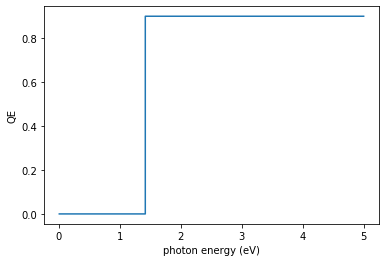

In [2]:
qe=gen_step_qe_array(1.42,0.9)
plt.plot(qe[:,0],qe[:,1])
plt.xlabel('photon energy (eV)')
plt.ylabel('QE')

```qe``` is a numpy array. The recommeneded way to handle it is converting it to ```Spectrum``` class:

In [3]:
qe_sp=Spectrum(x_data=qe[:,0],y_data=qe[:,1],x_unit='eV')

### Unit conversion
When we want to retrieve the value of ```qe_sp``` we have to specicify the unit of the wavelength. For example, say, converting the wavelength to nanometer:

(300, 1100)

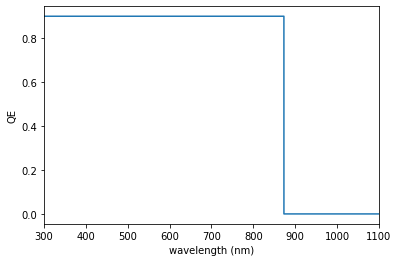

In [4]:
qe=qe_sp.get_spectrum(to_x_unit='nm')
plt.plot(qe[0,:],qe[1,:])
plt.xlabel('wavelength (nm)')
plt.ylabel('QE')
plt.xlim([300,1100])

### Arithmetic operation
We can do arithmetic operation directly with Spectrum class such as

In [5]:
# Calulate the portion of "non-absorbed" photons, assuming QE is equivalent to absorptivity
tr_sp=1-qe_sp

(300, 1100)

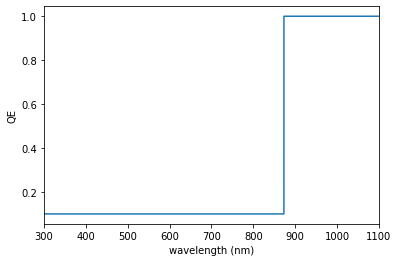

In [6]:
tr=tr_sp.get_spectrum(to_x_unit='nm')
plt.plot(tr[0,:],tr[1,:])
plt.xlabel('wavelength (nm)')
plt.ylabel('QE')
plt.xlim([300,1100])

## Illumination spectrum
pypvcell has a class Illumination that is inherited from ```Spectrum``` to handle the illumination. It inherits all the capability of ```Spectrum``` but has several methods specifically for sun illumination.

Some default standard spectrum is embedded in the ```pypvcell```:

In [7]:
std_ill=Illumination("AM1.5g")

Show the values of the data

Text(0, 0.5, 'intensity (W/m^2-nm)')

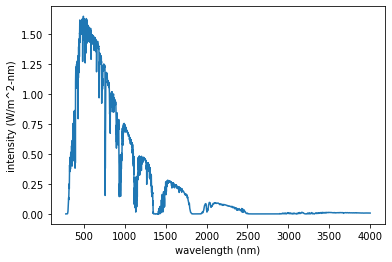

In [8]:
ill=std_ill.get_spectrum('nm')
plt.plot(*ill)
plt.xlabel("wavelength (nm)")
plt.ylabel("intensity (W/m^2-nm)")

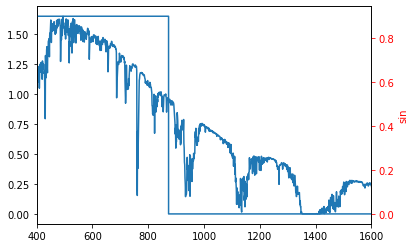

In [9]:
fig, ax1= plt.subplots()
ax1.plot(*ill)
ax2 = ax1.twinx()
ax2.plot(*qe)
ax1.set_xlim([400,1600])
ax2.set_ylabel('sin', color='r')
ax2.tick_params('y', colors='r')

In [10]:
ill[:,-1]

array([4.0000e+03, 7.1043e-03])

In [11]:
qe[:,-1]

array([1.23984204e+05, 1.00000000e-03])

Calcuate the total intensity in W/m^2

In [12]:
std_ill.total_power()

1000.3706555734423

### Unit conversion of illumination spectrum
It requires a bit of attention of converting spectrum that is in the form of $\phi(E)dE$, i.e., the value of integration is a meaningful quantitfy such as total power. This has been also handled by ```Illumination``` class. In the following case, we convert the wavelength to eV. Please note that the units of intensity is also changed to W/m^2-eV.

Text(0, 0.5, 'intensity (W/m^2-eV)')

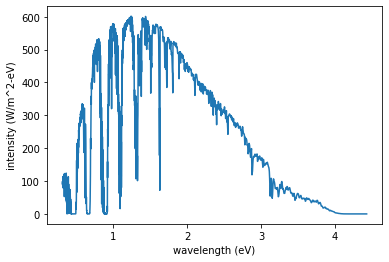

In [13]:
ill=std_ill.get_spectrum('eV')
plt.plot(*ill)
plt.xlabel("wavelength (eV)")
plt.ylabel("intensity (W/m^2-eV)")

## Spectrum multiplication
To calcualte the overall photocurrent, we have to calculate $\phi(E)QE(E) dE$ first. This would involves some unit conversion and interpolation between two spectrum. However, this is easily dealt by ```Spectrum``` class:

In [14]:
# calculate \phi(E)QE(E) dE. 
# Spectrum class automatically convert the units and align the x-data by interpolating std_ill
jsc_e=std_ill*qe_sp

Here's a more delicate point. We should convert the unit to photon flux in order to calculate Jsc.

(300, 1100)

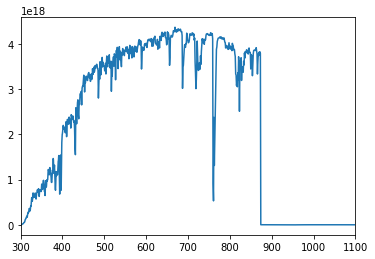

In [15]:
jsc_e_a=jsc_e.get_spectrum('nm',to_photon_flux=True)
plt.plot(*jsc_e_a)
plt.xlim([300,1100])

Integrate it yields the total photocurrent density in A/m^2

In [16]:
sc.e*np.trapz(y=jsc_e_a[1,:],x=jsc_e_a[0,:])

289.0589774322053

In fact, ```pypvcell``` already provides a function ```calc_jsc()``` for calculating Jsc from given spectrum and QE:

In [17]:
from pypvcell.photocurrent import calc_jsc
calc_jsc(std_ill,qe_sp)

288.81502713416893